# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE,Isomap
import warnings
warnings.filterwarnings('ignore')
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 64,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
dirpath = './datasets/Yale_face_database/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (165, 64, 64, 3)


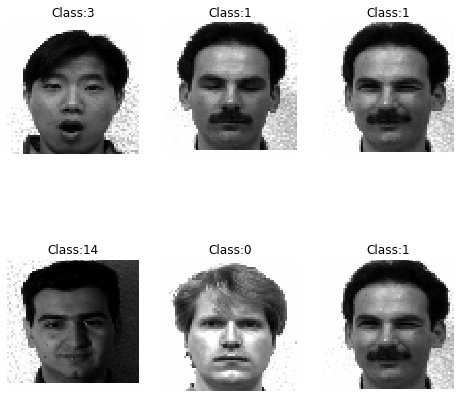

In [5]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

Dataset shape: (400, 64, 64, 3)


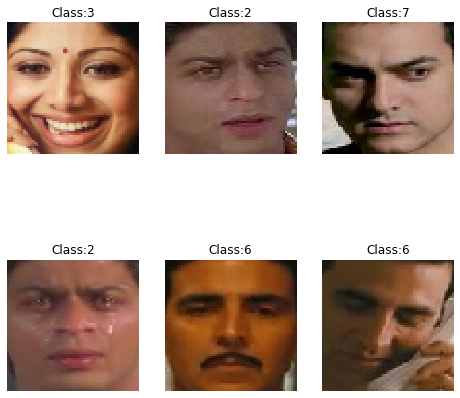

In [6]:
# Loading the dataset
dirpath1 = './datasets/IMFDB/'
X1,y1 = load_data(dirpath1)
N1,H1,W1 = X1.shape[0:3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]
# Show sample images
ind = np.random.randint(0,y1.shape[0],6)
disply_images(X1[ind,...],y1[ind], row=2,col=3)

Dataset shape: (672, 64, 64, 3)


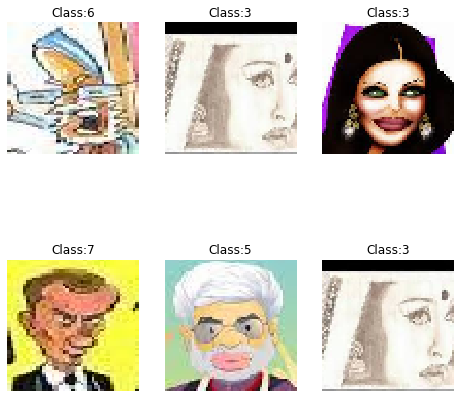

In [7]:
# Loading the dataset
dirpath2 = './datasets/IIIT-CFW/'
X2,y2 = load_data(dirpath2)
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]
# Show sample images
ind = np.random.randint(0,y2.shape[0],6)
disply_images(X2[ind,...],y2[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [8]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [9]:
X1 = X1.reshape((N1,H1*W1*C1))
X2 = X2.reshape((N2,H2*W2*C2))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [10]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    # Projected data into k dimensions
    X_k = pca.fit_transform(X)
    # Reconstructed data from k dimensions
    rec_X = pca.inverse_transform(X_k)
    return X_k,rec_X,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [11]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,remove_zero_eig=True)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [12]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [13]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k,klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [14]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [15]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________



1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [16]:
# Compute your features 
# eg.
X_pca,_,_ = get_pca(X,165)
X1_pca,_,_ = get_pca(X1,400)
X2_pca,_,_ = get_pca(X2,672)
print(X_pca.shape)
print(X1_pca.shape)
print(X2_pca.shape)

(165, 165)
(400, 400)
(672, 672)


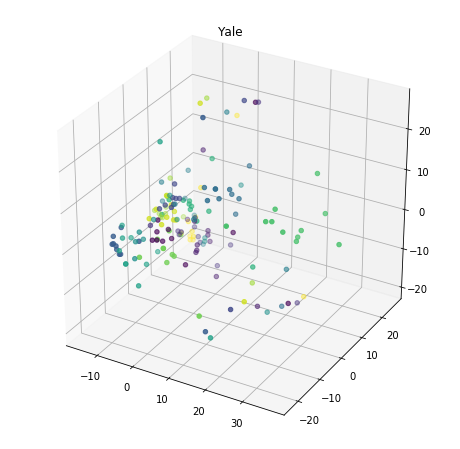

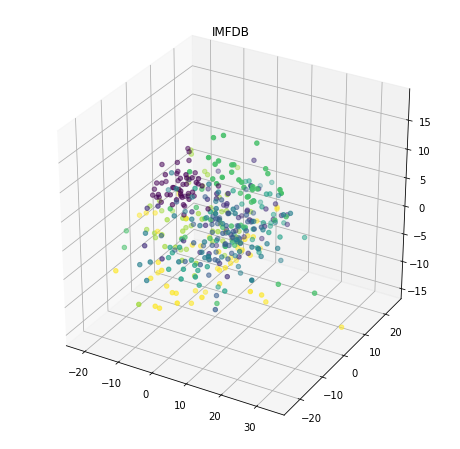

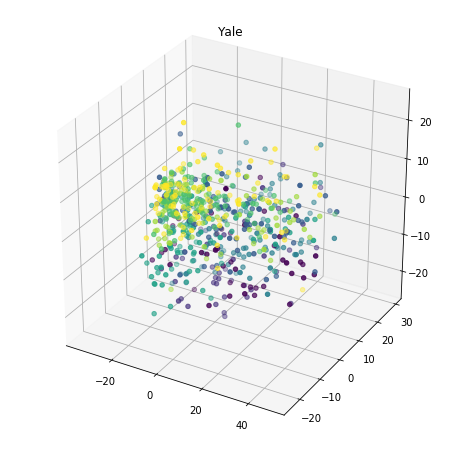

In [17]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=y)
plt.title("Yale")
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_pca[:,0],X1_pca[:,1],X1_pca[:,2],c=y1)
plt.title("IMFDB")
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2_pca[:,0],X2_pca[:,1],X2_pca[:,2],c=y2)
plt.title("Yale")
plt.show()

(165, 165)


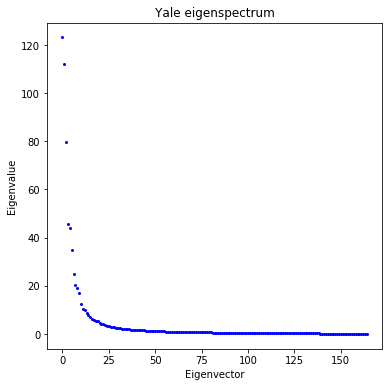

0.9510058019565669


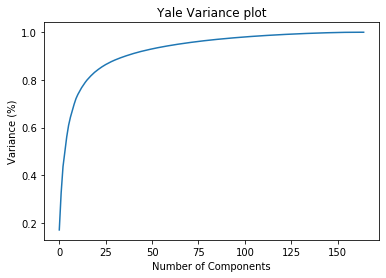

(400, 400)


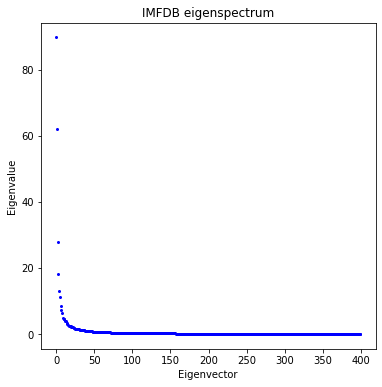

0.9504165265458536


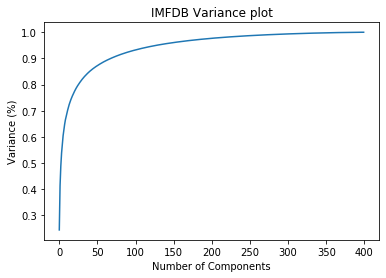

(672, 672)


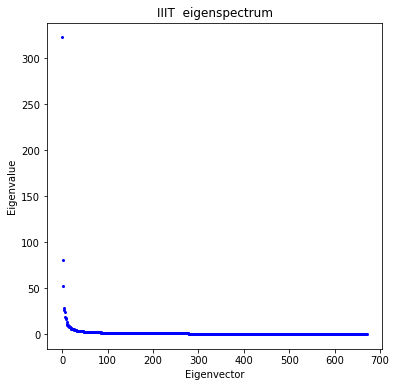

0.9501853619825317


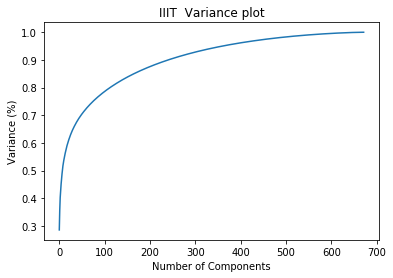

In [18]:
# Plot the eigen value spectrum 
# CANCER
def plot_eigen_spectrum(X,s):
    fig = plt.figure(figsize=(6,6))
    cov = np.cov(X,rowvar=False)
    print(cov.shape)
    n=0
    eigvals,_ = np.linalg.eigh(cov)
    desc_eigvals = eigvals[::-1]
    plt.plot(desc_eigvals,'bo',markersize=2)
    plt.xlabel("Eigenvector")
    plt.ylabel("Eigenvalue")
    plt.title(s+' eigenspectrum')
    plt.show()
    significance = [np.abs(i)/np.sum(desc_eigvals) for i in desc_eigvals]
    for i,val in enumerate(np.cumsum(significance)):
        if val>=0.95:
            n = i
            print(val)
            break
        
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure()
    plt.plot(np.cumsum(significance))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title(s+' Variance plot')
    plt.show()
    return n

n = plot_eigen_spectrum(X_pca,"Yale")    
n1 = plot_eigen_spectrum(X1_pca,"IMFDB")    
n2 = plot_eigen_spectrum(X2_pca,"IIIT ")    


In [19]:
#For 95% reconstruction, number of components :
# print("Yale:",n)
# print("IMFDB",n1)
# print("IIIT-CNM",n2)

In [20]:
# # if not running above two cells
n = 65
n1 = 128
n2 = 360

1(c). Reconstruct  the  image  back for each case


In [21]:
def reconstruct_images(X,k):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    X_k, reconstruct_X,_ = get_pca(X,k)
    print(reconstruct_X.shape)
    
    return X_k,reconstruct_X

65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(165, 12288)


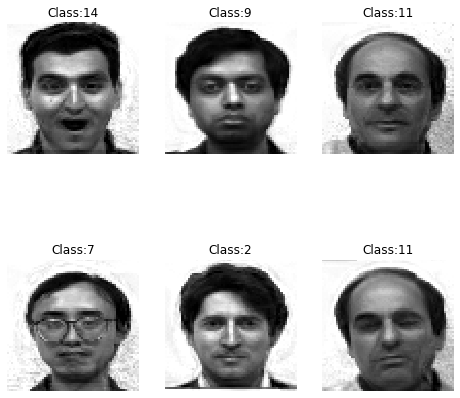

0.05423238017561792


In [22]:
# Display results
print(n)
X_pcaz,X_reconstructed = reconstruct_images(X,n)

X_reconstruced_3d = X_reconstructed.reshape((N,H,W,C))
# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstruced_3d[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(400, 12288)


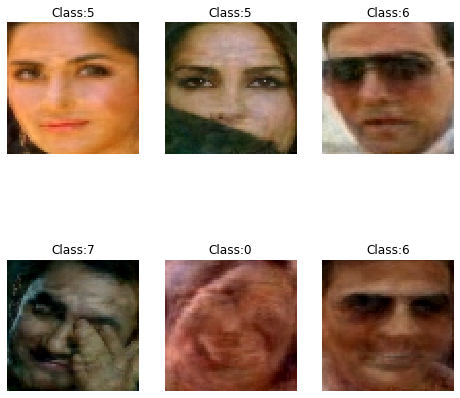

0.03881851836224732


In [23]:
X_pcaz1,X_reconstructed1 = reconstruct_images(X1,n1)

X_reconstruced_3d1 = X_reconstructed1.reshape((N1,H1,W1,C1))
# Display random images
ind = np.random.randint(0,y1.shape[0],6)
disply_images(X_reconstruced_3d1[ind,...],y1[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X1 - X_reconstructed1)**2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(672, 12288)


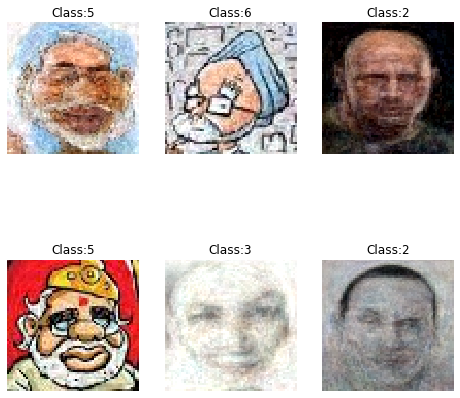

0.06855940771604219


In [24]:
X_pcaz2,X_reconstructed2 = reconstruct_images(X2,n2)

X_reconstruced_3d2 = X_reconstructed2.reshape((N2,H2,W2,C2))
# Display random images
ind = np.random.randint(0,y2.shape[0],6)
disply_images(X_reconstruced_3d2[ind,...],y2[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X2 - X_reconstructed2)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [25]:
# code goes here
# Doing for Yale : 
print('Yale')
pca = PCA(n_components=n)
# Projected data into k dimensions
X_k = pca.fit_transform(X)
errs = []
for i in range(8):
    # get the projected class data
    class_data = X_k[y==i]
    # Reconstructed data from k dimensions
    rec_class = pca.inverse_transform(class_data)
    # Show the reconstruction error
    er = np.sqrt(np.mean((X[y==i] - rec_class)**2))
    print("Class reconstruction error",i,":",er)
    errs.append(er)
errs = np.array(errs)
max_err_class = np.argmax(errs)
print("Max reconstruction error for class:",max_err_class)

# Doing for Imfdb : 
print('IMFDB')
pca = PCA(n_components=n1)
# Projected data into k dimensions
X_k = pca.fit_transform(X1)
errs1 = []
for i in range(8):
    # get the projected class data
    class_data = X_k[y1==i]
    # Reconstructed data from k dimensions
    rec_class = pca.inverse_transform(class_data)
    # Show the reconstruction error
    er = np.sqrt(np.mean((X1[y1==i] - rec_class)**2))
    print("Class reconstruction error",i,":",er)
    errs1.append(er)
errs1 = np.array(errs1)
max_err_class1 = np.argmax(errs1)
print("Max reconstruction error for class:",max_err_class1)   

# Doing for IIIT-CFM : 
print('IIIT-CFM')
pca = PCA(n_components=n2)
# Projected data into k dimensions
X_k = pca.fit_transform(X2)
errs2 = []
for i in range(8):
    # get the projected class data
    class_data = X_k[y2==i]
    # Reconstructed data from k dimensions
    rec_class = pca.inverse_transform(class_data)
    # Show the reconstruction error
    er = np.sqrt(np.mean((X2[y2==i] - rec_class)**2))
    print("Class reconstruction error",i,":",er)
    errs2.append(er)
errs2 = np.array(errs2)
max_err_class2 = np.argmax(errs2)
print("Max reconstruction error for class:",max_err_class2)

Yale
Class reconstruction error 0 : 0.058851333113025685
Class reconstruction error 1 : 0.05359232723325897
Class reconstruction error 2 : 0.04762392732624582
Class reconstruction error 3 : 0.05793969959395749
Class reconstruction error 4 : 0.05374840851745625
Class reconstruction error 5 : 0.05518495163545558
Class reconstruction error 6 : 0.0529689354493743
Class reconstruction error 7 : 0.054386998416384696
Max reconstruction error for class: 0
IMFDB
Class reconstruction error 0 : 0.03746369459202891
Class reconstruction error 1 : 0.039029483617401904
Class reconstruction error 2 : 0.04056881549108616
Class reconstruction error 3 : 0.039091935894479374
Class reconstruction error 4 : 0.03875524456547953
Class reconstruction error 5 : 0.03760473733584625
Class reconstruction error 6 : 0.04024187740360627
Class reconstruction error 7 : 0.03768151746131928
Max reconstruction error for class: 2
IIIT-CFM
Class reconstruction error 0 : 0.06904002708030399
Class reconstruction error 1 : 0.0

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [26]:
class Classifier():
    def __init__(self,hls,mi):
        self.classifier = MLPClassifier(hidden_layer_sizes=hls, max_iter=mi,activation = 'relu',solver='adam',random_state=1)
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        y_pred = self.classifier.predict(X)
        return y_pred
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(y,pred)
        return cm
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train, y_train)


        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        predicted = self.classify(X_validate)

        # Create a confusion matrix
        confusion = self.confusion_matrix(predicted,y_validate)
        
        # Calculate Validation accuracy 
        val_accuracy = self.classifier.score(X_validate,y_validate)
    
        # Calculate precision and recall 
        precision = precision_score(y_validate,predicted,average='macro')
        recall = recall_score(y_validate,predicted,average='macro')
        # Calculate F1-score
        f1 = f1_score(y_validate,predicted,average='macro')
        
        return predicted,confusion,val_accuracy,precision,recall,f1

In [27]:
# Create a train and validation split to train your classifier 
#Splitting the dataset into  training and validation sets
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 21)
X1_train, X1_test,y1_train,y1_test = train_test_split(X1,y1, test_size = 0.25, random_state = 21)
X2_train, X2_test,y2_train,y2_test = train_test_split(X2,y2, test_size = 0.25, random_state = 21)


In [28]:
# Feature extraction for VGG and resnet
X_vgg = get_vgg_features('./datasets/Yale_face_database/')
X_res = get_resnet_features('./datasets/Yale_face_database/')
X1_vgg = get_vgg_features('./datasets/IMFDB/')
X1_res = get_resnet_features('./datasets/IMFDB/')
X2_vgg = get_vgg_features('./datasets/IIIT-CFW/')
X2_res = get_resnet_features('./datasets/IIIT-CFW/')

X_train_vgg, X_test_vgg,y_train_vgg,y_test_vgg = train_test_split(X_vgg,y, test_size = 0.25, random_state = 21)
X1_train_vgg, X1_test_vgg,y1_train_vgg,y1_test_vgg = train_test_split(X1_vgg,y1, test_size = 0.25, random_state = 21)
X2_train_vgg, X2_test_vgg,y2_train_vgg,y2_test_vgg = train_test_split(X2_vgg,y2, test_size = 0.25, random_state = 21)

X_train_res, X_test_res,y_train_res,y_test_res = train_test_split(X_res,y, test_size = 0.25, random_state = 21)
X1_train_res, X1_test_res,y1_train_res,y1_test_res = train_test_split(X1_res,y1, test_size = 0.25, random_state = 21)
X2_train_res, X2_test_res,y2_train_res,y2_test_res = train_test_split(X2_res,y2, test_size = 0.25, random_state = 21)


In [29]:
#Test sample on yale for pca using mlp
X_train_pca,_,X_model_pca = get_pca(X_train,n)
c = Classifier((1000,1000),350)
c.train(X_train_pca,y_train)
X_test_pca = X_model_pca.transform(X_test)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_pca,y_test)
print(val_accuracy*100)

83.33333333333334


In [30]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
# Print the table. (You can use Pandas)

feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n,n,14,14]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X_train_projected,_,X_model = ft(X_train,components[i])
    elif i==1:#kpca
        X_train_projected,X_model = ft(X_train,components[i])
    else:#lda and klda
        X_train_projected,X_model = ft(X_train,y_train,components[i])
        
    c = Classifier((1000,1000),350)
    c.train(X_train_projected,y_train)
    X_test_projected = X_model.transform(X_test)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected,y_test)

    lst.extend([titles[i],X_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X_vgg,X_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y, test_size = 0.2, random_state = 21)
    c = Classifier((1000,1000),350)
    c.train(training_data,training_labels)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X_train_projected_vgg,X_model = get_lda(X_train_vgg,y_train_vgg,14)
c = Classifier((1000,1000),350)
c.train(X_train_projected_vgg,y_train_vgg)
X_test_projected_vgg = X_model.transform(X_test_vgg)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected_vgg,y_test_vgg)

lst.extend(['LDA of VGG',X_train_projected_vgg.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X_train_projected_res,_,X_model = get_pca(X_train_res,n)
c = Classifier((1000,1000),350)
c.train(X_train_projected_res,y_train_res)
X_test_projected_res = X_model.transform(X_test_res)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected_res,y_test_res)

lst.extend(['PCA of resnet',X_train_projected_res.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Classification error','Accuracy','F1 score']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Classification error    Accuracy  F1 score
                             PCA                         65             16.666667   83.333333  0.836735
              Kernel PCA(poly=3)                         65              7.142857   92.857143  0.875556
                             LDA                         14              0.000000  100.000000  1.000000
              Kernel LDA(poly=3)                         14              0.000000  100.000000  1.000000
                             VGG                         14             39.393939   60.606061  0.565629
                          Resnet                         14              0.000000  100.000000  1.000000
                      LDA of VGG                         14             35.714286   64.285714  0.61595

In [31]:
# For imfdb
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n1,n1,7,7]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat1 = []
cfs1 = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X1_train_projected,_,X1_model = ft(X1_train,components[i])
    elif i==1:#kpca
        X1_train_projected,X1_model = ft(X1_train,components[i])
    else:#lda and klda
        X1_train_projected,X1_model = ft(X1_train,y1_train,components[i])
        
    c = Classifier((1000,1000),350)
    c.train(X1_train_projected,y1_train)
    X1_test_projected = X1_model.transform(X1_test)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected,y1_test)

    lst.extend([titles[i],X1_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
    mat1.append(lst)
    cfs1.append(confusion)

features =  [X1_vgg,X1_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y1, test_size = 0.2, random_state = 21)
    c = Classifier((1000,1000),350)
    c.train(training_data,training_labels)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X1_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1])   
    mat1.append(lst)
    cfs1.append(confusion)

# LDA of VGG
lst = []
X1_train_projected_vgg,X1_model = get_lda(X1_train_vgg,y1_train_vgg,7)
c = Classifier((1000,1000),350)
c.train(X1_train_projected_vgg,y1_train_vgg)
X1_test_projected_vgg = X1_model.transform(X1_test_vgg)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected_vgg,y1_test_vgg)

lst.extend(['LDA of VGG',X1_train_projected_vgg.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat1.append(lst)
cfs1.append(confusion)
    
# PCA of resnet
lst = []
X1_train_projected_res,_,X1_model = get_pca(X1_train_res,n)
c = Classifier((1000,1000),350)
c.train(X1_train_projected_res,y1_train_res)
X1_test_projected_res = X1_model.transform(X1_test_res)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected_res,y1_test_res)

lst.extend(['PCA of resnet',X1_train_projected_res.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat1.append(lst)
cfs1.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat1)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Classification error','Accuracy','F1 score']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Classification error  Accuracy  F1 score
                             PCA                        128                 13.00     87.00  0.874592
              Kernel PCA(poly=3)                        128                 17.00     83.00  0.835527
                             LDA                          7                 25.00     75.00  0.751871
              Kernel LDA(poly=3)                          7                 25.00     75.00  0.751871
                             VGG                          7                 10.00     90.00  0.908798
                          Resnet                          7                  8.75     91.25  0.917343
                      LDA of VGG                          7                 44.00     56.00  0.555811
              

In [32]:
# For iiit-cfm
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n2,n2,7,7]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat2 = []
cfs2 = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X2_train_projected,_,X2_model = ft(X2_train,components[i])
    elif i==1:#kpca
        X2_train_projected,X2_model = ft(X2_train,components[i])
    else:#lda and klda
        X2_train_projected,X2_model = ft(X2_train,y2_train,components[i])
        
    c = Classifier((1000,1000),350)
    c.train(X2_train_projected,y2_train)
    X2_test_projected = X2_model.transform(X2_test)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X2_test_projected,y2_test)

    lst.extend([titles[i],X2_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
    mat2.append(lst)
    cfs2.append(confusion)

features =  [X2_vgg,X2_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y2, test_size = 0.2, random_state = 21)
    c = Classifier((1000,1000),350)
    c.train(training_data,training_labels)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X2_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1])   
    mat2.append(lst)
    cfs2.append(confusion)

# LDA of VGG
lst = []
X2_train_projected_vgg,X2_model = get_lda(X2_train_vgg,y2_train_vgg,7)
c = Classifier((1000,1000),350)
c.train(X2_train_projected_vgg,y2_train_vgg)
X2_test_projected_vgg = X2_model.transform(X2_test_vgg)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X2_test_projected_vgg,y2_test_vgg)

lst.extend(['LDA of VGG',X2_train_projected_vgg.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat2.append(lst)
cfs2.append(confusion)
    
# PCA of resnet
lst = []
X2_train_projected_res,_,X2_model = get_pca(X2_train_res,n)
c = Classifier((1000,1000),350)
c.train(X2_train_projected_res,y2_train_res)
X2_test_projected_res = X2_model.transform(X2_test_res)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X2_test_projected_res,y2_test_res)

lst.extend(['PCA of resnet',X2_train_projected_res.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat2.append(lst)
cfs2.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat2)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Classification error','Accuracy','F1 score']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Classification error   Accuracy  F1 score
                             PCA                        360             35.714286  64.285714  0.639830
              Kernel PCA(poly=3)                        360             35.714286  64.285714  0.625336
                             LDA                          7             63.095238  36.904762  0.362442
              Kernel LDA(poly=3)                          7             63.095238  36.904762  0.362442
                             VGG                          7             29.629630  70.370370  0.667560
                          Resnet                          7              1.481481  98.518519  0.985303
                      LDA of VGG                          7             41.666667  58.333333  0.552684
      

In [33]:
print(len(cfs))

8


For Yale, Resnet gave best results


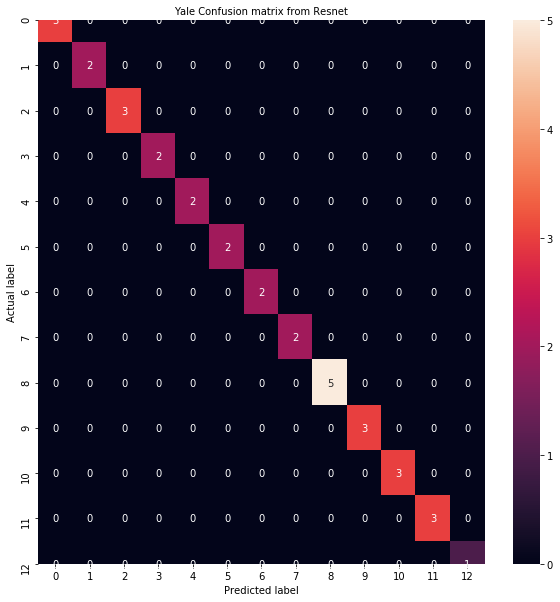

For IMFDB,  PCA of Resnet gave best results


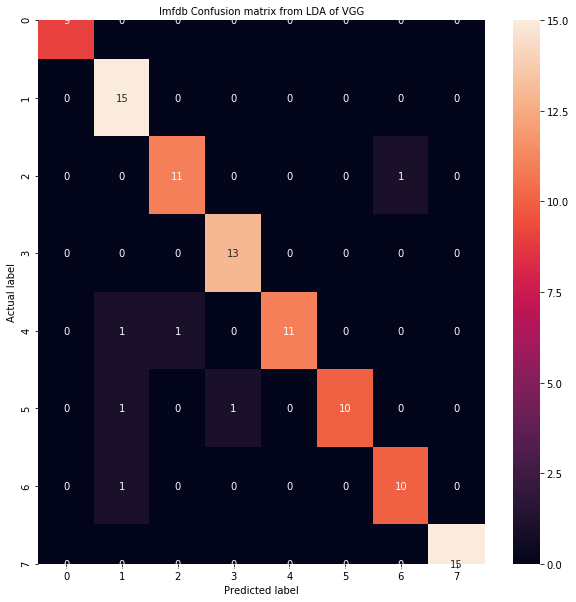

For IIIT-CFM, PCA of Resnet gave best results


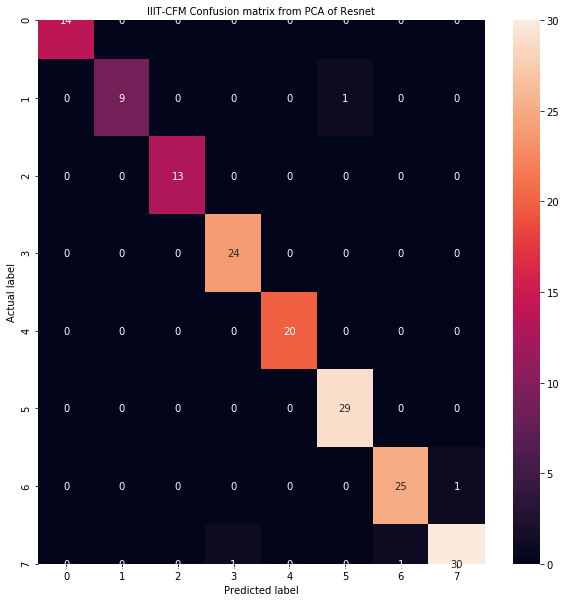

In [34]:
# For each dataset print the confusion matrix for the best model 
def print_heatmap(cm,d,s):
    plt.figure(figsize=(10,10))
    sns.heatmap(cm,annot=True)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title(d+' Confusion matrix '+s, size = 10)
    plt.show()
    
print("For Yale, Resnet gave best results")
print_heatmap(cfs[5],'Yale','from Resnet')
print("For IMFDB,  PCA of Resnet gave best results")
print_heatmap(cfs1[7],'Imfdb','from LDA of VGG')
print("For IIIT-CFM, PCA of Resnet gave best results")
print_heatmap(cfs2[7],'IIIT-CFM','from PCA of Resnet')


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

TSNE on Yale PCA
Reduced dimensions: (165, 3)


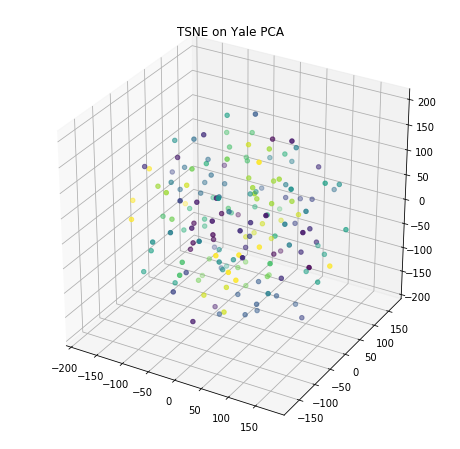

TSNE on IMFDB PCA
Reduced dimensions: (400, 3)


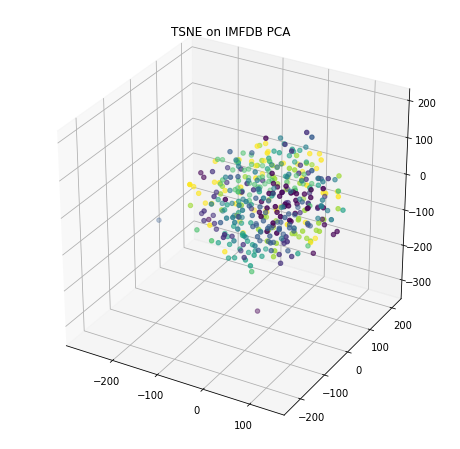

TSNE on IIIT-CFM PCA
Reduced dimensions: (672, 3)


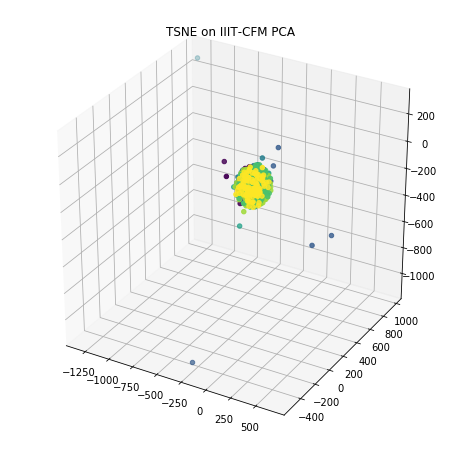

In [35]:
# Compute TSNE for different features and create a scatter plot
def TSNE_features(data,y,k,s):
    print(s)
    # Compute
    X_TSNE = TSNE(n_components=k).fit_transform(data)
    print("Reduced dimensions:",X_TSNE.shape)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the representation in 2d/3d
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    plt.title(s)
    plt.show()

titles = ["TSNE on Yale","TSNE on IMFDB","TSNE on IIIT-CFM"]
ys = [y,y1,y2]
for i,p in enumerate([X_pcaz,X_pcaz1,X_pcaz2]):
    TSNE_features(p,ys[i],3,titles[i]+" PCA")



(1237, 1)
(1237, 12288)
TSNE on all data LDA
Reduced dimensions: (1237, 3)


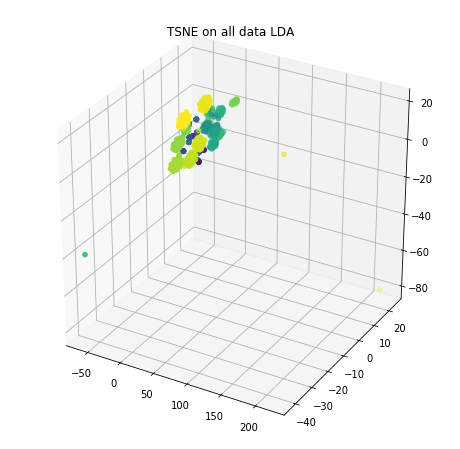

In [36]:
XX = np.vstack((X,X1,X2))
yy = np.vstack((y.reshape(165,1),(y1+15).reshape(400,1),(y2+15+8).reshape(672,1)))
print(yy.shape)
print(XX.shape)
yy = yy.reshape(1237)
lda_XX = get_lda(XX,yy,30)[0]
TSNE_features(lda_XX,yy,3,"TSNE on all data LDA")

TSNE on all data LDA
Reduced dimensions: (165, 3)


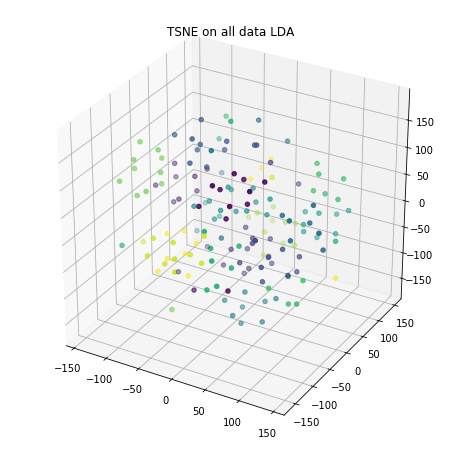

TSNE on all data LDA
Reduced dimensions: (400, 3)


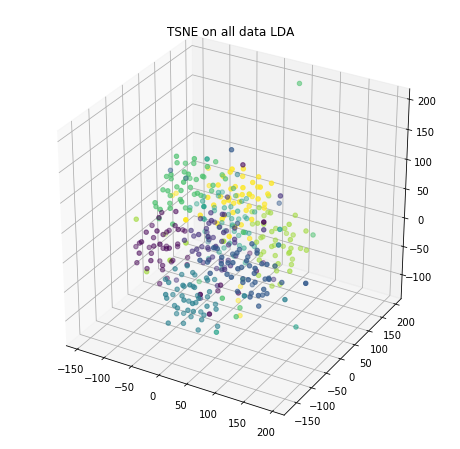

TSNE on all data LDA
Reduced dimensions: (672, 3)


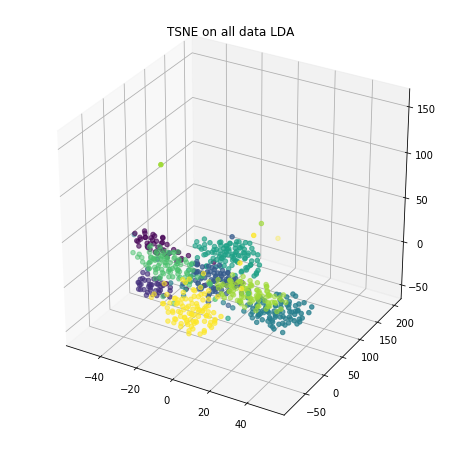

In [37]:
ldas = [get_lda(X,y,14)[0],get_lda(X1,y1,7)[0],get_lda(X2,y2,7)[0]]
for i,p in enumerate(ldas):
    TSNE_features(p,ys[i],3,"TSNE on all data LDA")

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [38]:
class FaceVerification():
    def __init__(self,k):
        self.knn = KNeighborsClassifier(n_neighbors=k)

    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,y):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        predictions = self.knn.predict(X)
        results = (predictions==y)
        return results,predictions

    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.knn.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        accuracy = self.knn.score(X_validate,y_validate)*100
        error = 100 - accuracy
        precision = precision_score(y_validate,self.verify(X_validate,y_validate)[1],average='macro')
        return accuracy, error, precision

In [39]:
# Create a train and validation split and show your results
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 21)
X1_train, X1_test,y1_train,y1_test = train_test_split(X1,y1, test_size = 0.25, random_state = 21)
X2_train, X2_test,y2_train,y2_test = train_test_split(X2,y2, test_size = 0.25, random_state = 21)
# Feature extraction for VGG and resnet
X_vgg = get_vgg_features('./datasets/Yale_face_database/')
X_res = get_resnet_features('./datasets/Yale_face_database/')
X1_vgg = get_vgg_features('./datasets/IMFDB/')
X1_res = get_resnet_features('./datasets/IMFDB/')
X2_vgg = get_vgg_features('./datasets/IIIT-CFW/')
X2_res = get_resnet_features('./datasets/IIIT-CFW/')

X_train_vgg, X_test_vgg,y_train_vgg,y_test_vgg = train_test_split(X_vgg,y, test_size = 0.25, random_state = 21)
X1_train_vgg, X1_test_vgg,y1_train_vgg,y1_test_vgg = train_test_split(X1_vgg,y1, test_size = 0.25, random_state = 21)
X2_train_vgg, X2_test_vgg,y2_train_vgg,y2_test_vgg = train_test_split(X2_vgg,y2, test_size = 0.25, random_state = 21)

X_train_res, X_test_res,y_train_res,y_test_res = train_test_split(X_res,y, test_size = 0.25, random_state = 21)
X1_train_res, X1_test_res,y1_train_res,y1_test_res = train_test_split(X1_res,y1, test_size = 0.25, random_state = 21)
X2_train_res, X2_test_res,y2_train_res,y2_test_res = train_test_split(X2_res,y2, test_size = 0.25, random_state = 21)

In [40]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda ]  
components = [n,n,14,14]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X_train_projected,_,X_model = ft(X_train,components[i])
    elif i==1:#kpca
        X_train_projected,X_model = ft(X_train,components[i])
    else:#lda and klda
        X_train_projected,X_model = ft(X_train,y_train,components[i])
        
    c = FaceVerification(5)
    c.train(X_train_projected,y_train)
    X_test_projected = X_model.transform(X_test)
    val_accuracy,error,precision = c.validate(X_test_projected,y_test)

    lst.extend([titles[i],X_train_projected.shape[1],val_accuracy,error,precision]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X_vgg,X_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y, test_size = 0.2, random_state = 21)
    c = FaceVerification(5)
    c.train(training_data,training_labels)
    val_accuracy,error,precision = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X_train_projected.shape[1],val_accuracy,error,precision])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X_train_projected_vgg,X_model = get_lda(X_train_vgg,y_train_vgg,14)
c = FaceVerification(5)
c.train(X_train_projected_vgg,y_train_vgg)
X_test_projected_vgg = X_model.transform(X_test_vgg)
val_accuracy,error,precision = c.validate(X_test_projected_vgg,y_test_vgg)

lst.extend(['LDA of VGG',X_train_projected_vgg.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X_train_projected_res,_,X_model = get_pca(X_train_res,n)
c = FaceVerification(5)
c.train(X_train_projected_res,y_train_res)
X_test_projected_res = X_model.transform(X_test_res)
val_accuracy,error,precision = c.validate(X_test_projected_res,y_test_res)

lst.extend(['PCA of resnet',X_train_projected_res.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Accuracy','Classification error','Precision']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space    Accuracy  Classification error  Precision
                             PCA                         65   80.952381             19.047619   0.861111
              Kernel PCA(poly=3)                         65   80.952381             19.047619   0.861111
                             LDA                         14   92.857143              7.142857   0.940476
              Kernel LDA(poly=3)                         14   92.857143              7.142857   0.940476
                             VGG                         14   69.696970             30.303030   0.666667
                          Resnet                         14  100.000000              0.000000   1.000000
                      LDA of VGG                         14   69.047619             30.952381  

In [41]:
lst = []
for t in [3,5,7,9,12]:
    X_train_projected,X_model = get_lda(X_train,y_train,14)
    c = FaceVerification(t)
    c.train(X_train_projected,y_train)
    X_test_projected = X_model.transform(X_test)
    val_accuracy,error,precision = c.validate(X_test_projected,y_test)
    lst.append([t,val_accuracy,precision])    
df = pd.DataFrame(lst)
df.columns = ['K','Accuracy','Precision']
# Print the output.
print(df.to_string(index=False)) 

  K   Accuracy  Precision
  3  95.238095   0.958333
  5  92.857143   0.940476
  7  95.238095   0.964286
  9  95.238095   0.964286
 12  92.857143   0.940476


In [42]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n1,n1,7,7]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X1_train_projected,_,X1_model = ft(X1_train,components[i])
    elif i==1:#kpca
        X1_train_projected,X1_model = ft(X1_train,components[i])
    else:#lda and klda
        X1_train_projected,X1_model = ft(X1_train,y1_train,components[i])
        
    c = FaceVerification(5)
    c.train(X1_train_projected,y1_train)
    X1_test_projected = X1_model.transform(X1_test)
    val_accuracy,error,precision = c.validate(X1_test_projected,y1_test)

    lst.extend([titles[i],X1_train_projected.shape[1],val_accuracy,error,precision]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X1_vgg,X1_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y1, test_size = 0.2, random_state = 21)
    c = FaceVerification(5)
    c.train(training_data,training_labels)
    val_accuracy,error,precision = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X1_train_projected.shape[1],val_accuracy,error,precision])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X1_train_projected_vgg,X1_model = get_lda(X1_train_vgg,y1_train_vgg,14)
c = FaceVerification(5)
c.train(X1_train_projected_vgg,y1_train_vgg)
X1_test_projected_vgg = X1_model.transform(X1_test_vgg)
val_accuracy,error,precision = c.validate(X1_test_projected_vgg,y1_test_vgg)

lst.extend(['LDA of VGG',X1_train_projected_vgg.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X1_train_projected_res,_,X1_model = get_pca(X1_train_res,n)
c = FaceVerification(5)
c.train(X1_train_projected_res,y1_train_res)
X1_test_projected_res = X1_model.transform(X1_test_res)
val_accuracy,error,precision = c.validate(X1_test_projected_res,y1_test_res)

lst.extend(['PCA of resnet',X1_train_projected_res.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Accuracy','Classification error','Precision']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Accuracy  Classification error  Precision
                             PCA                        128     54.00                 46.00   0.567178
              Kernel PCA(poly=3)                        128     54.00                 46.00   0.563839
                             LDA                          7     82.00                 18.00   0.828730
              Kernel LDA(poly=3)                          7     82.00                 18.00   0.828730
                             VGG                          7     91.25                  8.75   0.906534
                          Resnet                          7     92.50                  7.50   0.934325
                      LDA of VGG                          7     63.00                 37.00   0.659220
      

In [43]:
lst = []
for t in [3,5,7,9,12]:
    X1_train_projected,X1_model = get_lda(X1_train,y1_train,14)
    c = FaceVerification(t)
    c.train(X1_train_projected,y1_train)
    X1_test_projected = X1_model.transform(X1_test)
    val_accuracy,error,precision = c.validate(X1_test_projected,y1_test)
    lst.append([t,val_accuracy,precision])    
df = pd.DataFrame(lst)
df.columns = ['K','Accuracy','Precision']
# Print the output.
print(df.to_string(index=False))    

  K  Accuracy  Precision
  3      83.0   0.833820
  5      82.0   0.828730
  7      82.0   0.825753
  9      82.0   0.832089
 12      81.0   0.817054


In [44]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n2,n2,7,7]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X2_train_projected,_,X2_model = ft(X2_train,components[i])
    elif i==1:#kpca
        X2_train_projected,X2_model = ft(X2_train,components[i])
    else:#lda and klda
        X2_train_projected,X2_model = ft(X2_train,y2_train,components[i])
        
    c = FaceVerification(5)
    c.train(X2_train_projected,y2_train)
    X2_test_projected = X2_model.transform(X2_test)
    val_accuracy,error,precision = c.validate(X2_test_projected,y2_test)

    lst.extend([titles[i],X2_train_projected.shape[1],val_accuracy,error,precision]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X2_vgg,X2_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y2, test_size = 0.2, random_state = 21)
    c = FaceVerification(5)
    c.train(training_data,training_labels)
    val_accuracy,error,precision = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X2_train_projected.shape[1],val_accuracy,error,precision])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X2_train_projected_vgg,X2_model = get_lda(X2_train_vgg,y2_train_vgg,14)
c = FaceVerification(5)
c.train(X2_train_projected_vgg,y2_train_vgg)
X2_test_projected_vgg = X2_model.transform(X2_test_vgg)
val_accuracy,error,precision = c.validate(X2_test_projected_vgg,y2_test_vgg)

lst.extend(['LDA of VGG',X2_train_projected_vgg.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X2_train_projected_res,_,X2_model = get_pca(X2_train_res,n)
c = FaceVerification(5)
c.train(X2_train_projected_res,y2_train_res)
X2_test_projected_res = X2_model.transform(X2_test_res)
val_accuracy,error,precision = c.validate(X2_test_projected_res,y2_test_res)

lst.extend(['PCA of resnet',X2_train_projected_res.shape[1],val_accuracy,error,precision]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Accuracy','Classification error','Precision']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space   Accuracy  Classification error  Precision
                             PCA                        360  23.809524             76.190476   0.497569
              Kernel PCA(poly=3)                        360  25.000000             75.000000   0.521742
                             LDA                          7  45.238095             54.761905   0.473022
              Kernel LDA(poly=3)                          7  45.238095             54.761905   0.473022
                             VGG                          7  68.148148             31.851852   0.650242
                          Resnet                          7  97.777778              2.222222   0.980176
                      LDA of VGG                          7  60.119048             39.880952   0.54957

In [45]:
lst = []
for t in [3,5,7,9,12]:
    X2_train_projected,X2_model = get_lda(X2_train,y2_train,14)
    c = FaceVerification(t)
    c.train(X2_train_projected,y2_train)
    X2_test_projected = X2_model.transform(X2_test)
    val_accuracy,error,precision = c.validate(X2_test_projected,y2_test)
    lst.append([t,val_accuracy,precision])    
df = pd.DataFrame(lst)
df.columns = ['K','Accuracy','Precision']
# Print the output.
print(df.to_string(index=False))    

  K   Accuracy  Precision
  3  41.666667   0.444979
  5  45.238095   0.473022
  7  45.238095   0.460913
  9  44.047619   0.453854
 12  44.642857   0.459166


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [46]:
# Load data
# Load the full data from directory

def load_data(dirpath,fname):
    emo_dict = dict()
    with open(fname) as f:
        content = f.readlines()
        names = [x.strip().split('.')[0] for x in content]
        emotions = [x.strip().split('.')[1].split(',')[1] for x in content]
    for i,name in enumerate(names):    
        emo_dict[name] = emotions[i]

    y_list = []
    image_list = []
    i=0
    for filename in sorted(os.listdir(dirpath)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dirpath,filename))
            y = filename.split('.')[0]
            # print(y,end=' ')
            y = emo_dict[y] 
            image_list.append(im)
            y_list.append(y)
            # print(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)
    le = preprocessing.LabelEncoder()
    le.fit(np.unique(y_list))
    y_list_enc = le.transform(y_list)

    return image_list,y_list_enc,le

# X1,y1
print('Imfdb')
dirpath1 = './datasets/IMFDB/'   
X1_data,y1,le1 = load_data(dirpath1,dirpath1+'emotion.txt')
X1 = X1_data.reshape((N1,H1*W1*C1))
print("Linearized shape:",X1.shape)
# X,y
print('Yale')
dirpath = './datasets/Yale_face_database/'   
X_data,y,le = load_data(dirpath,dirpath+'emotion.txt')
X = X_data.reshape((N,H*W*C))
print("Linearized shape:",X.shape)


Imfdb
Dataset shape: (400, 64, 64, 3)
Linearized shape: (400, 12288)
Yale
Dataset shape: (165, 64, 64, 3)
Linearized shape: (165, 12288)


In [47]:
# Define your features
# Do train test split
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X1_train, X1_test,y1_train,y1_test = train_test_split(X1,y1, test_size = 0.2, random_state = 42)
# Feature extraction for VGG and resnet
X_vgg = get_vgg_features('./datasets/Yale_face_database/')
X_res = get_resnet_features('./datasets/Yale_face_database/')
X1_vgg = get_vgg_features('./datasets/IMFDB/')
X1_res = get_resnet_features('./datasets/IMFDB/')

X_train_vgg, X_test_vgg,y_train_vgg,y_test_vgg = train_test_split(X_vgg,y, test_size = 0.2, random_state = 42)
X1_train_vgg, X1_test_vgg,y1_train_vgg,y1_test_vgg = train_test_split(X1_vgg,y1, test_size = 0.2, random_state = 42)

X_train_res, X_test_res,y_train_res,y_test_res = train_test_split(X_res,y, test_size = 0.2, random_state = 42)
X1_train_res, X1_test_res,y1_train_res,y1_test_res = train_test_split(X1_res,y1, test_size = 0.2, random_state = 42)



In [48]:
class LogClassifier():
    def __init__(self):
        # self.classifier = LogisticRegression(C=10, solver='lbfgs',max_iter=1000,multi_class='multinomial',penalty='l2')
        self.classifier = LogisticRegression(C=0.01)
    def classify(self,X):
        y_pred = self.classifier.predict(X)
        return y_pred    
    def confusion_matrix(self,pred,y):
        cm = confusion_matrix(y,pred)
        return cm        
    def train(self,X_train,y_train):
        self.classifier.fit(X_train, y_train)     
    def validate(self,X_validate,y_validate):
        predicted = self.classify(X_validate)
        confusion = self.confusion_matrix(predicted,y_validate)
        val_accuracy = self.classifier.score(X_validate,y_validate)
        precision = precision_score(y_validate,predicted,average='macro')
        recall = recall_score(y_validate,predicted,average='macro')
        f1 = f1_score(y_validate,predicted,average='macro')
        return predicted,confusion,val_accuracy,precision,recall,f1

In [49]:
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n,n,10,10]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X_train_projected,_,X_model = ft(X_train,components[i])
    elif i==1:#kpca
        X_train_projected,X_model = ft(X_train,components[i])
    else:#lda and klda
        X_train_projected,X_model = ft(X_train,y_train,components[i])
        
    c = LogClassifier()
    c.train(X_train_projected,y_train)
    X_test_projected = X_model.transform(X_test)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected,y_test)

    lst.extend([titles[i],X_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X_vgg,X_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y, test_size = 0.2, random_state = 21)
    c = LogClassifier()
    c.train(training_data,training_labels)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X_train_projected_vgg,X_model = get_lda(X_train_vgg,y_train_vgg,14)
c = LogClassifier()
c.train(X_train_projected_vgg,y_train_vgg)
X_test_projected_vgg = X_model.transform(X_test_vgg)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected_vgg,y_test_vgg)

lst.extend(['LDA of VGG',X_train_projected_vgg.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X_train_projected_res,_,X_model = get_pca(X_train_res,n)
c = LogClassifier()
c.train(X_train_projected_res,y_train_res)
X_test_projected_res = X_model.transform(X_test_res)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X_test_projected_res,y_test_res)

lst.extend(['PCA of resnet',X_train_projected_res.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Classification error','Accuracy','F1 score']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Classification error   Accuracy  F1 score
                             PCA                         65             57.575758  42.424242  0.348196
              Kernel PCA(poly=3)                         65             93.939394   6.060606  0.072727
                             LDA                         10             45.454545  54.545455  0.453247
              Kernel LDA(poly=3)                         10             45.454545  54.545455  0.453247
                             VGG                         10             93.939394   6.060606  0.050505
                          Resnet                         10            100.000000   0.000000  0.000000
                      LDA of VGG                         10             96.969697   3.030303  0.036364
      

In [50]:
feature_transforms = [get_pca,\
    get_kernel_pca,\
    get_lda,\
    get_kernel_lda]  
components = [n1,n1,10,10]
titles = ["PCA",'Kernel PCA(poly=3)','LDA','Kernel LDA(poly=3)']

mat = []
cfs = []
for i,ft in enumerate(feature_transforms):
    print(i,ft)
    lst = []
    if i==0:#pca
        X1_train_projected,_,X1_model = ft(X1_train,components[i])
    elif i==1:#kpca
        X1_train_projected,X1_model = ft(X1_train,components[i])
    else:#lda and klda
        X1_train_projected,X1_model = ft(X1_train,y1_train,components[i])
        
    c = LogClassifier()
    c.train(X1_train_projected,y1_train)
    X1_test_projected = X1_model.transform(X1_test)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected,y1_test)

    lst.extend([titles[i],X1_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
    mat.append(lst)
    cfs.append(confusion)

features =  [X1_vgg,X1_res]
titles = ['VGG','Resnet']
for i,ft in enumerate(features):
    lst = []
    training_data, validation_data, training_labels, validation_labels = train_test_split(ft,y1, test_size = 0.2, random_state = 21)
    c = LogClassifier()
    c.train(training_data,training_labels)
    predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(validation_data,validation_labels)
    lst.extend([titles[i],X1_train_projected.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1])   
    mat.append(lst)
    cfs.append(confusion)

# LDA of VGG
lst = []
X1_train_projected_vgg,X1_model = get_lda(X1_train_vgg,y1_train_vgg,14)
c = LogClassifier()
c.train(X1_train_projected_vgg,y1_train_vgg)
X1_test_projected_vgg = X1_model.transform(X1_test_vgg)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected_vgg,y1_test_vgg)

lst.extend(['LDA of VGG',X1_train_projected_vgg.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)
    
# PCA of resnet
lst = []
X1_train_projected_res,_,X1_model = get_pca(X1_train_res,n)
c = LogClassifier()
c.train(X1_train_projected_res,y1_train_res)
X1_test_projected_res = X1_model.transform(X1_test_res)
predicted,confusion,val_accuracy,precision,recall,f1 = c.validate(X1_test_projected_res,y1_test_res)

lst.extend(['PCA of resnet',X1_train_projected_res.shape[1],(1-val_accuracy)*100,val_accuracy*100,f1]) 
mat.append(lst)
cfs.append(confusion)

# Create DataFrame
df = pd.DataFrame(mat)
df.columns = ['Features/Combination of features','Reduced Dimensional Space','Classification error','Accuracy','F1 score']
# Print the output.
print(df.to_string(index=False))

0 <function get_pca at 0x7fd3b405e1e0>
1 <function get_kernel_pca at 0x7fd380ee22f0>
2 <function get_lda at 0x7fd380ee26a8>
3 <function get_kernel_lda at 0x7fd380ee2d90>
Features/Combination of features  Reduced Dimensional Space  Classification error  Accuracy  F1 score
                             PCA                        128                 37.50     62.50  0.413417
              Kernel PCA(poly=3)                        128                 65.00     35.00  0.086420
                             LDA                          6                 46.25     53.75  0.345039
              Kernel LDA(poly=3)                          6                 46.25     53.75  0.345039
                             VGG                          6                 51.25     48.75  0.316835
                          Resnet                          6                 47.50     52.50  0.349534
                      LDA of VGG                          6                 73.75     26.25  0.182424
              

TSNE on Yale LDA
Reduced dimensions: (165, 3)


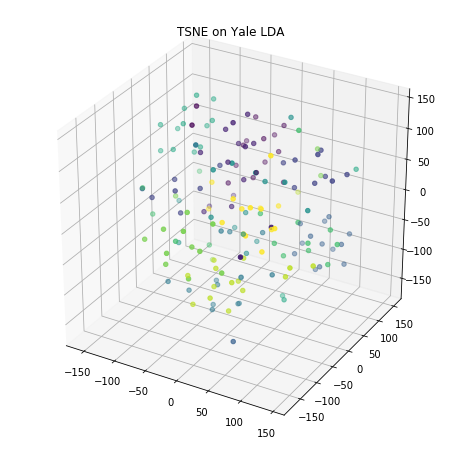

TSNE on IMFDB LDA
Reduced dimensions: (400, 3)


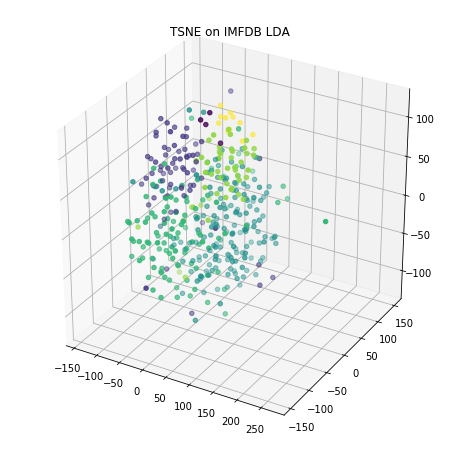

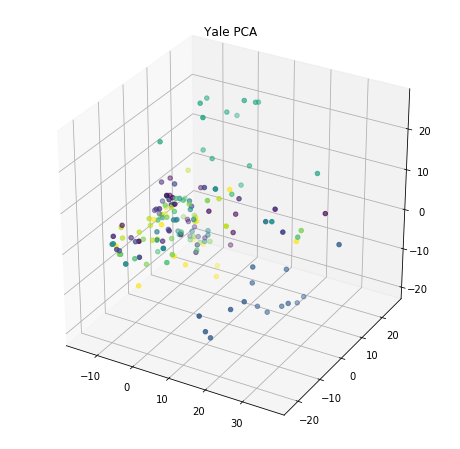

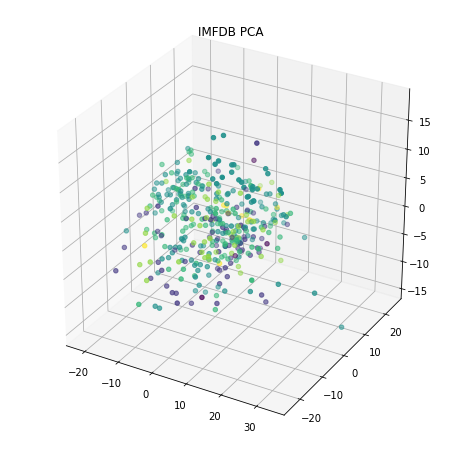

In [51]:
# TSNE on LDA and PCA plots
ldas = [get_lda(X,y,10)[0],get_lda(X1,y1,6)[0]]
ys = [y,y1]
titles = ["TSNE on Yale LDA","TSNE on IMFDB LDA"]
for i,p in enumerate(ldas):
    TSNE_features(p,ys[i],3,titles[i])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=y)
plt.title("Yale PCA" )
plt.show()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_pca[:,0],X1_pca[:,1],X1_pca[:,2],c=y1)
plt.title("IMFDB PCA")
plt.show()



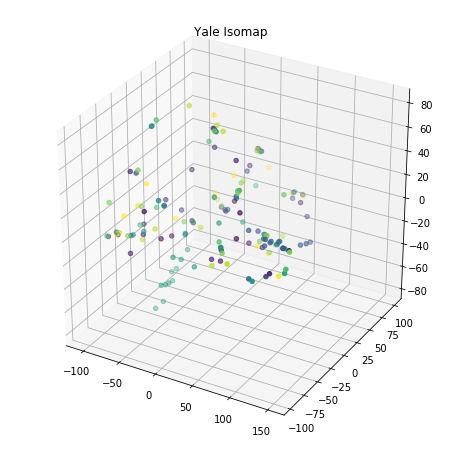

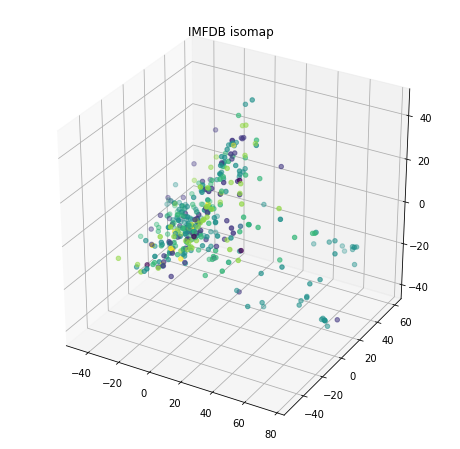

In [52]:
embedding = Isomap(n_components=3)
X_i = embedding.fit_transform(X)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_i[:,0],X_i[:,1],X_i[:,2],c=y)
plt.title("Yale Isomap" )
plt.show()
embedding = Isomap(n_components=3)
X_i = embedding.fit_transform(X1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_i[:,0],X_i[:,1],X_i[:,2],c=y1)
plt.title("IMFDB isomap" )
plt.show()

In [53]:
def kfold(Xp,yp,ks):
    mat = []
    p = ks.shape[0]
    for nf in ks:
        kf = KFold(n_splits=nf,shuffle=True)
        kf.get_n_splits(Xp)
        accuracies = []
        precisions = []
        for train_index, test_index in kf.split(Xp):
            X_train, X_test = Xp[train_index], Xp[test_index]
            y_train, y_test = yp[train_index], yp[test_index]

            X_train_projected,X_model = get_lda(X_train,y_train,10)
            c = LogClassifier()
            c.train(X_train_projected,y_train)
            
            X_test_projected = X_model.transform(X_test)
            _,_,val_accuracy,precision,_,_ = c.validate(X_test_projected,y_test)
            accuracies.append(val_accuracy)
            precisions.append(precision)
        accuracies = np.array(accuracies)
        precisions = np.array(precisions)
        acc = np.mean(accuracies)
        prec = np.mean(precisions)
        mat.append([acc*100,prec])
    matrix = np.array(mat)
    ks =np.array(ks).reshape(p,1)
    matrix = np.concatenate((ks,matrix),axis=1)    
    return matrix

ks = np.arange(3,24,3)
print("For yale:")
mat = kfold(X,y,ks)
df = pd.DataFrame(mat)
df.columns = ['K splits','Accuracy','Precision']
# Print the output.
print(df.to_string(index=False))
print("For IMFDB:")
mat = kfold(X1,y1,ks)
df = pd.DataFrame(mat)
df.columns = ['K splits','Accuracy','Precision']
# Print the output.
print(df.to_string(index=False))

For yale:
 K splits   Accuracy  Precision
      3.0  35.757576   0.392593
      6.0  44.863316   0.477670
      9.0  48.570500   0.471927
     12.0  46.108059   0.421489
     15.0  49.696970   0.456536
     18.0  52.037037   0.463845
     21.0  48.979592   0.397392
For IMFDB:
 K splits   Accuracy  Precision
      3.0  53.759398   0.358752
      6.0  53.018996   0.385536
      9.0  53.507295   0.381626
     12.0  51.002674   0.383780
     15.0  53.770180   0.409587
     18.0  53.985507   0.467392
     21.0  54.010025   0.446059


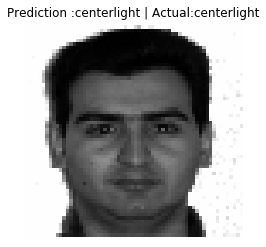

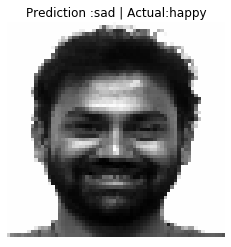

In [54]:
# Show quantitative results such as examples of correct prediction and wrong prediction
X_train_projected,_,X_model = get_pca(X_train,65)
c = LogClassifier()
c.train(X_train_projected,y_train)
X_test_projected = X_model.transform(X_test)
predicted,_,acc,_,_,_ = c.validate(X_test_projected,y_test)
mask = (predicted==y_test)
nt = X_test.shape[0]
X_3d = X_test.reshape((nt,H,W,C))
ft = np.where(mask==True)[0][0]
ff = np.where(mask==False)[0][0]
plt.imshow(X_3d[ft])
plt.title("Prediction :"+str(le.inverse_transform([predicted[ft]])[0])+" | Actual:"+str(le.inverse_transform([y_test[ft]])[0]) )
plt.axis('off')
plt.show()
plt.imshow(X_3d[ff])
plt.title("Prediction :"+str(le.inverse_transform([predicted[ff]])[0])+" | Actual:"+str(le.inverse_transform([y_test[ff]])[0]) )
plt.axis('off')
plt.show()

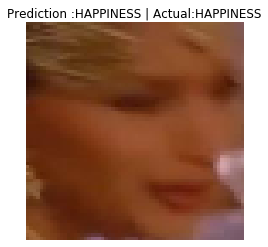

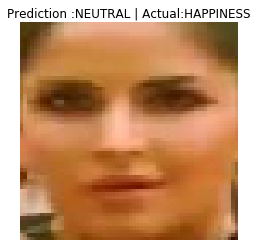

In [55]:
# Show quantitative results such as examples of correct prediction and wrong prediction
X1_train_projected,_,X1_model = get_pca(X1_train,65)
c = LogClassifier()
c.train(X1_train_projected,y1_train)
X1_test_projected = X1_model.transform(X1_test)
predicted,_,acc,_,_,_ = c.validate(X1_test_projected,y1_test)
mask = (predicted==y1_test)
nt = X1_test.shape[0]
X1_3d = X1_test.reshape((nt,H,W,C))
ft = np.where(mask==True)[0][0]
ff = np.where(mask==False)[0][0]
plt.imshow(X1_3d[ft])
plt.title("Prediction :"+str(le1.inverse_transform([predicted[ft]])[0])+" | Actual:"+str(le1.inverse_transform([y1_test[ft]])[0]) )
plt.axis('off')
plt.show()
plt.imshow(X1_3d[ff])
plt.title("Prediction :"+str(le1.inverse_transform([predicted[ff]])[0])+" | Actual:"+str(le1.inverse_transform([y1_test[ff]])[0]) )
plt.axis('off')
plt.show()